In [1]:
import pandas as pd
import numpy as np

from ast import literal_eval

from scipy.stats import entropy

code2lang = {
    'ar': 'ara', 'de': 'deu', 'en': 'eng', 'es': 'spa', 'fr': 'fra', 'hi': 'hin',
    'id': 'ind', 'it': 'ita', 'ja': 'jpn', 'ko': 'kor', 'pt': 'por', 'ru': 'rus',
    'tr': 'tur', 'vi': 'vie', 'zh': 'zho'}
iso3names = {
    'ara': 'Arabic', 'deu': 'German', 'eng': 'English', 'spa': 'Spanish',
    'fra': 'French', 'hin': 'Hindi', 'ind': 'Indonesian', 'ita': 'Italian',
    'jpn': 'Japanese', 'kor': 'Korean', 'por': 'Portuguese', 'rus': 'Russian',
    'tur': 'Turkish', 'vie': 'Vietnamese', 'zho': 'Chinese'
}


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import defaultdict
import os
from tqdm import tqdm
from scipy.stats import entropy
%matplotlib inline

In [3]:
llm_dict = {
        'command-r-base': "Command R base", 'command-r': "Command R",
        'command-r-plus-base': "Command R+ base", 'command-r-plus': "Command R+",
        'gpt-3.5-turbo': "GPT-3.5 Turbo", 'gpt-4-turbo': "GPT-4 Turbo",
        'mistral-large': "Mistral Large", 'mistral-8x7b': "Mistral 8x7B",
        'llama-2-instruct': "Llama 2 70B-I", 'llama-3-instruct': "Llama 3 70B-I"}

In [4]:
report_models = ["command-r",  "command-r-plus", "gpt-3.5-turbo", "gpt-4-turbo", "mistral-large", "mistral-8x7b", 
                 "llama-2-instruct", "llama-3-instruct"]

In [7]:
df.head(2)

,LLM,source,lang,task,avg_line_weighted_entropy,avg_word_weighted_entropy,lpr,wpr
0,command-r,aya-human-annotated,ara,monolingual,0.000000,0.178040,NaN,NaN
1,command-r,aya-human-annotated,eng,monolingual,0.010732,0.293924,NaN,NaN


In [8]:
df = pd.read_csv("../datasets/prompts_language_confusion/results/reweighted_entropy_passrates.csv")

In [9]:
df.head(2)

,LLM,source,lang,task,avg_line_weighted_entropy,avg_word_weighted_entropy,lpr,wpr
0,command-r,aya-human-annotated,ara,monolingual,0.000000,0.178040,NaN,NaN
1,command-r,aya-human-annotated,eng,monolingual,0.010732,0.293924,NaN,NaN


In [10]:
df = df[df["LLM"].isin(report_models)]

In [11]:
df["LLM_name"] = df["LLM"].map(llm_dict)

In [12]:
df["Language"]=df["lang"].map(iso3names)

In [13]:
lang_order= ['fra',
 'spa',
 'ita',
 'deu',
 'rus',
 'por',
 'tur',
 'vie',
 'zho',
 'kor',
 'ara',
 'jpn',
 'hin',
 'ind']
df['lang_avg_entropy'] = pd.Categorical(df['lang'], categories=lang_order, ordered=True)
df["LLM"] = pd.Categorical(df["LLM"], categories=report_models,ordered=True)
df_sorted= df.sort_values(by=["lang_avg_entropy", "LLM"])

In [14]:
df_sorted =df_sorted.reset_index()

In [15]:
df_sorted["LLM"].value_counts()

LLM
command-r           66
command-r-plus      66
gpt-3.5-turbo       66
gpt-4-turbo         66
mistral-large       66
mistral-8x7b        66
llama-2-instruct    66
llama-3-instruct    66
Name: count, dtype: int64

In [16]:
df_sorted["source"].value_counts()

source
okapi                  192
complex-prompts        112
sharegpt               112
dolly-human-edited      40
aya-human-annotated     40
native-prompts          32
Name: count, dtype: int64

# Output tables

# Data sources per language

In [19]:
def plot_source_per_lang(df,  by_entropy="weighted_entropy",  outputfile="test.pdf", generation_setting="crosslingual", level="line"):
    # Assuming df_eval_lang_entropy_melted contains columns: 'language', 'entropy', 'step', and 'f1_score'
    # Create the figure and the first axis (for entropy)
    fig, ax1 = plt.subplots(figsize=(30, 8))
    palette = sns.color_palette("colorblind", 6)
    colors=[palette[1], palette[4], palette[5]]

    df = df[df["task"]==generation_setting]
    p = sns.barplot(x='Language', y=f'avg_{level}_weighted_entropy', data=df,width=0.6, hue="source",gap=0.1, palette=colors, ax=ax1, ci=None)

  

    ax1.set_ylabel("Confusion Entropy", fontsize=34)
    ax1.set_xlabel('Language', fontsize=34)
    ax1.tick_params(axis='y', labelsize=26)
    ax1.tick_params(axis='x', labelsize=26)
    
    # Add the legend for the steps (can be adjusted for both y-axes)
    ax1.legend(title="Data Sources", fontsize=20, title_fontsize=24, loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.2)
   
    plt.tight_layout()
    plt.savefig(outputfile, format='pdf', bbox_inches='tight')

    
    plt.show()

/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_77234/3889700106.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  p = sns.barplot(x='Language', y=f'avg_{level}_weighted_entropy', data=df,width=0.6, hue="source",gap=0.1, palette=colors, ax=ax1, ci=None)


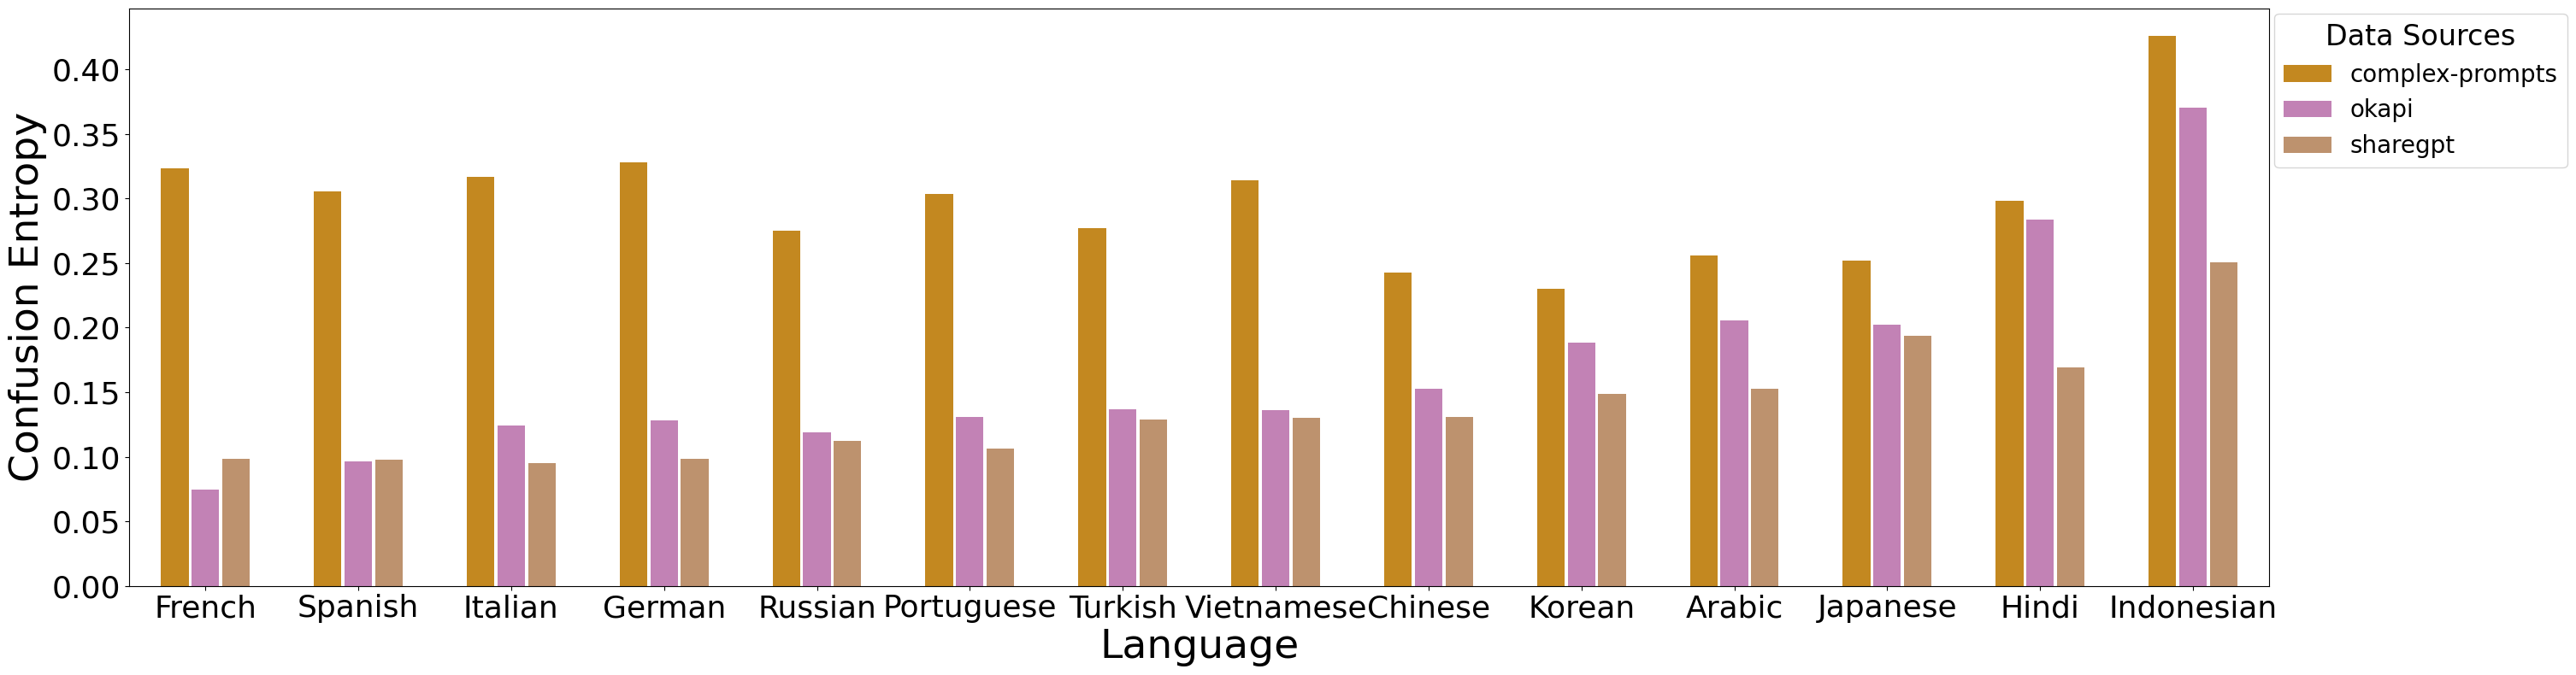

In [20]:
plot_source_per_lang(df_sorted,  by_entropy="weighted_entropy",  outputfile="../results/prompting_language_confusion/line_level_crosslingual_sources.pdf", generation_setting="crosslingual", level="line")

# Cross data sources

In [21]:
def plot_sources_box(df, outputfile="test.pdf", level="line"):
    fig, ax1 = plt.subplots(figsize=(8, 5))
    p = sns.boxplot(x='task', y=f'avg_{level}_weighted_entropy', data=df, hue="source", gap=0.2, palette="colorblind",
                    showfliers=False, whis=[5,95],
                    ax=ax1)

    ax1.set_ylabel("Confusion Entropy", fontsize=20)
    ax1.set_xlabel('Generation Setting', fontsize=20)
    ax1.tick_params(axis='y', labelsize=16)
    ax1.tick_params(axis='x', labelsize=16)
    
    ax1.legend(title=f"Data Sources", fontsize=14, title_fontsize=16, loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.2)
    plt.ylim(top=1.7)
    plt.title(f'{level.capitalize()} Level', fontsize=30)

    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(outputfile, format='pdf', bbox_inches='tight')
    
    plt.show()



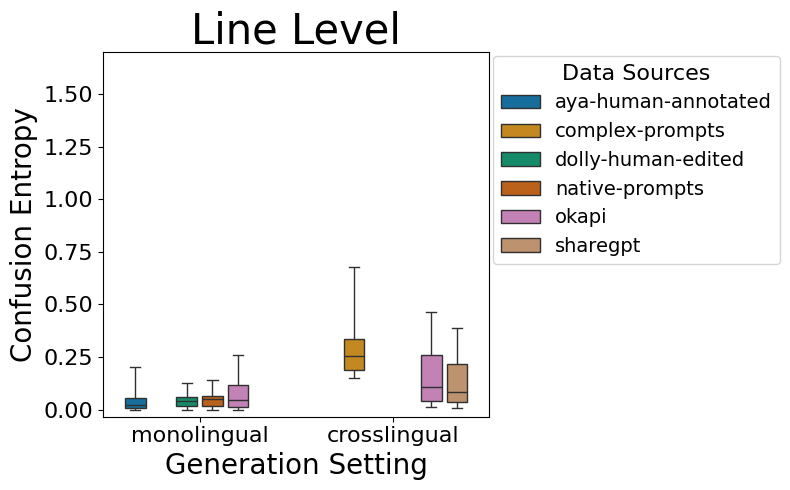

In [22]:
plot_sources_box(df,  outputfile="../results/prompting_language_confusion/line_level_sources_entropy.pdf", level="line")

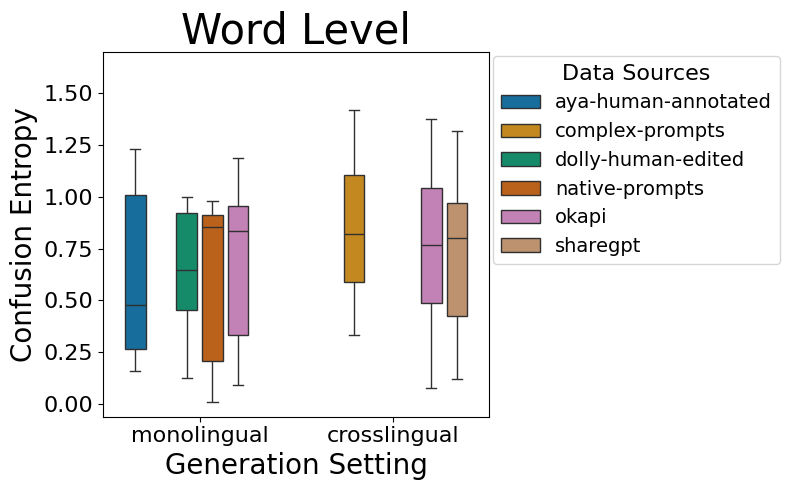

In [23]:
plot_sources_box(df, outputfile="../results/prompting_language_confusion/word_level_sources_entropy.pdf", level="word")

In [300]:
df_sorted.to_csv("../results/prompting_language_confusion/lcb_entropy.csv", index=False)

# Cross LLMs

In [24]:
def plot_llm_box(df,  outputfile="test.pdf", level="line"):
    fig, ax1 = plt.subplots(figsize=(8, 5))
    p = sns.boxplot(x='task', y=f'avg_{level}_weighted_entropy', data=df, hue="LLM_name", gap=0.2, palette="colorblind",
                    showfliers=False, whis=[5,95],
                    ax=ax1)

    ax1.set_ylabel("Confusion Entropy", fontsize=20)
    ax1.set_xlabel('Generation Setting', fontsize=20)
    ax1.tick_params(axis='y', labelsize=16)
    ax1.tick_params(axis='x', labelsize=16)
    
    ax1.legend(title=f"LLM", fontsize=14, title_fontsize=16, loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.2)
    plt.ylim(top=1.7)
    plt.title(f'{level.capitalize()} Level', fontsize=30)

    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(outputfile, format='pdf', bbox_inches='tight')
    
    plt.show()


In [ ]:
# get the order of monolingual and crosslingual

In [132]:
df_sorted.iloc[0], df_sorted.iloc[1] = df_sorted.iloc[1].copy(), df_sorted.iloc[0].copy()

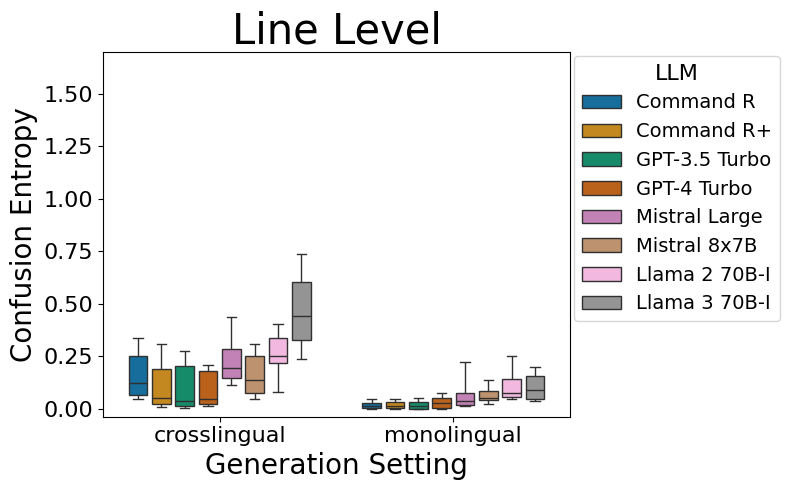

In [25]:
plot_llm_box(df_sorted,  outputfile="../results/prompting_language_confusion/line_level_llm_entropy.pdf", level="line")


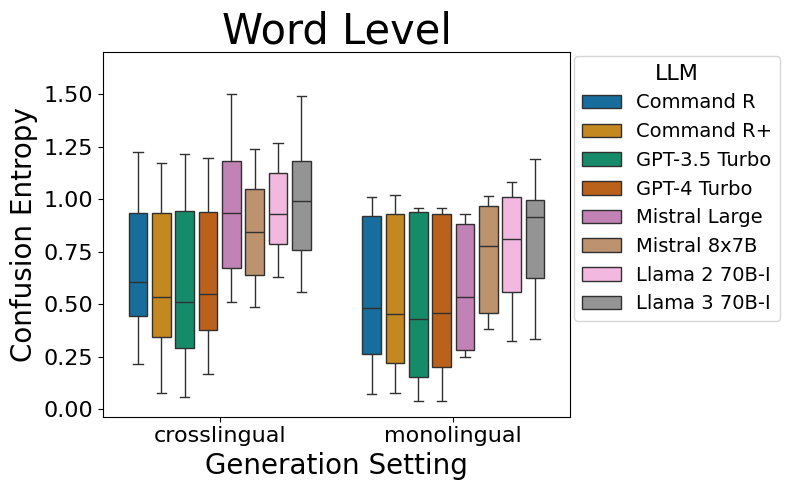

In [26]:
plot_llm_box(df_sorted, outputfile="../results/prompting_language_confusion/word_level_llm_entropy.pdf",level="word")


# line level 

In [27]:
df_line = df.dropna(subset=["avg_line_weighted_entropy"])

In [28]:
df_line_mono = df[df["task"]=="monolingual"]

In [29]:
df_line_mono.source.value_counts()

source
okapi                  80
aya-human-annotated    40
dolly-human-edited     40
native-prompts         32
Name: count, dtype: int64

In [30]:
df_lang_mono= df_line_mono.groupby(["LLM", "task", "lang"], as_index=False).agg( 
    avg_line_weighted_entropy_across_llm_source=("avg_line_weighted_entropy", 'mean'))

/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_77234/811767593.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lang_mono= df_line_mono.groupby(["LLM", "task", "lang"], as_index=False).agg(


In [31]:
df_lang_mono

,LLM,task,lang,avg_line_weighted_entropy_across_llm_source
0,command-r,monolingual,ara,0.001660
1,command-r,monolingual,deu,0.043040
2,command-r,monolingual,eng,0.016510
3,command-r,monolingual,fra,0.027221
4,command-r,monolingual,hin,0.011116
...,...,...,...,...
115,llama-3-instruct,monolingual,rus,0.095485
116,llama-3-instruct,monolingual,spa,0.055745
117,llama-3-instruct,monolingual,tur,0.200851
118,llama-3-instruct,monolingual,vie,0.141601


In [32]:
df_lang_mono

,LLM,task,lang,avg_line_weighted_entropy_across_llm_source
0,command-r,monolingual,ara,0.001660
1,command-r,monolingual,deu,0.043040
2,command-r,monolingual,eng,0.016510
3,command-r,monolingual,fra,0.027221
4,command-r,monolingual,hin,0.011116
...,...,...,...,...
115,llama-3-instruct,monolingual,rus,0.095485
116,llama-3-instruct,monolingual,spa,0.055745
117,llama-3-instruct,monolingual,tur,0.200851
118,llama-3-instruct,monolingual,vie,0.141601


In [33]:
df_line_mono['lang_avg_entropy'] = pd.Categorical(df_line_mono['lang'], categories=lang_order, ordered=True)
df_line_mono["LLM"] = pd.Categorical(df_line_mono["LLM"], categories=report_models,ordered=True)

/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_77234/2904432979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_line_mono['lang_avg_entropy'] = pd.Categorical(df_line_mono['lang'], categories=lang_order, ordered=True)
/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_77234/2904432979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_line_mono["LLM"] = pd.Categorical(df_line_mono["LLM"], categories=report_models,ordered=True)


In [34]:
lang_order

['fra',
 'spa',
 'ita',
 'deu',
 'rus',
 'por',
 'tur',
 'vie',
 'zho',
 'kor',
 'ara',
 'jpn',
 'hin',
 'ind']

In [35]:
langs= ["French", "Spanish", "Italian", "German", "Russian", "Portuguese", "Turkish", "Vietnamese", "Chinese", "Korean", "Arabic", 
        "Japanese", "Hindi", "Indonesian"]

In [36]:
df_line_mono_sorted= df_line_mono.sort_values(by=["lang_avg_entropy", "LLM"])

In [37]:
df_line_mono_sorted["source"].value_counts()

source
okapi                  80
dolly-human-edited     40
aya-human-annotated    40
native-prompts         32
Name: count, dtype: int64

In [38]:
df_line_mono_agg= df_line_mono_sorted.groupby(["LLM_name", "task", "Language"], as_index=False).agg( 
    avg_line_weighted_entropy_across_llm_source=("avg_line_weighted_entropy", 'mean'))

In [39]:
df_mono_line = df_line_mono_agg.pivot(index='LLM_name', columns='Language', values='avg_line_weighted_entropy_across_llm_source')


In [30]:
df_mono_line[langs].to_csv("../results/prompting_language_confusion/lcb_line_monolingual_languages_lc.csv")

In [40]:
df_mono_line[langs]

Language,French,Spanish,Italian,German,Russian,Portuguese,Turkish,Vietnamese,Chinese,Korean,Arabic,Japanese,Hindi,Indonesian
LLM_name,,,,,,,,,,,,,,
Command R,0.027221,0.038144,0.009165,0.043040,0.009312,0.019457,0.004185,0.009921,0.000000,0.000000,0.001660,0.017109,0.011116,0.238376
Command R+,0.012657,0.032514,0.000000,0.037325,0.030904,0.021950,0.009960,0.026374,0.000000,0.000000,0.003357,0.015823,0.038666,0.267332
GPT-3.5 Turbo,0.025039,0.029609,0.010261,0.027640,0.016781,0.029197,0.004980,0.006991,0.000000,0.000000,0.000000,0.005708,0.054628,0.233665
GPT-4 Turbo,0.050774,0.046769,0.005051,0.031628,0.063579,0.022799,0.000000,0.003329,0.007942,0.000000,0.000000,0.008309,0.063931,0.228926
Llama 2 70B-I,0.072892,0.054810,0.150020,0.143752,0.070439,0.056863,0.134742,0.250128,0.111322,0.050129,0.171334,0.078379,0.127877,0.299865
Llama 3 70B-I,0.048343,0.055745,0.029991,0.055593,0.095485,0.065421,0.200851,0.141601,0.151806,0.172050,0.187949,0.157902,0.171967,0.141249
Mistral 8x7B,0.039925,0.050960,0.064535,0.022878,0.041396,0.078394,0.025185,0.103743,0.111570,0.078738,0.058272,0.139370,0.054005,0.203630
Mistral Large,0.014477,0.035149,0.020223,0.013906,0.015555,0.064344,0.037757,0.224515,0.101135,0.032948,0.123144,0.075638,0.066274,0.293626


In [41]:
df_mono_line[langs]

Language,French,Spanish,Italian,German,Russian,Portuguese,Turkish,Vietnamese,Chinese,Korean,Arabic,Japanese,Hindi,Indonesian
LLM_name,,,,,,,,,,,,,,
Command R,0.027221,0.038144,0.009165,0.043040,0.009312,0.019457,0.004185,0.009921,0.000000,0.000000,0.001660,0.017109,0.011116,0.238376
Command R+,0.012657,0.032514,0.000000,0.037325,0.030904,0.021950,0.009960,0.026374,0.000000,0.000000,0.003357,0.015823,0.038666,0.267332
GPT-3.5 Turbo,0.025039,0.029609,0.010261,0.027640,0.016781,0.029197,0.004980,0.006991,0.000000,0.000000,0.000000,0.005708,0.054628,0.233665
GPT-4 Turbo,0.050774,0.046769,0.005051,0.031628,0.063579,0.022799,0.000000,0.003329,0.007942,0.000000,0.000000,0.008309,0.063931,0.228926
Llama 2 70B-I,0.072892,0.054810,0.150020,0.143752,0.070439,0.056863,0.134742,0.250128,0.111322,0.050129,0.171334,0.078379,0.127877,0.299865
Llama 3 70B-I,0.048343,0.055745,0.029991,0.055593,0.095485,0.065421,0.200851,0.141601,0.151806,0.172050,0.187949,0.157902,0.171967,0.141249
Mistral 8x7B,0.039925,0.050960,0.064535,0.022878,0.041396,0.078394,0.025185,0.103743,0.111570,0.078738,0.058272,0.139370,0.054005,0.203630
Mistral Large,0.014477,0.035149,0.020223,0.013906,0.015555,0.064344,0.037757,0.224515,0.101135,0.032948,0.123144,0.075638,0.066274,0.293626


/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_27094/3072051221.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  p = sns.barplot(x='Language', y=f'avg_{level}_weighted_entropy', data=df, hue="LLM_name", palette="colorblind", ax=ax1, ci=None)


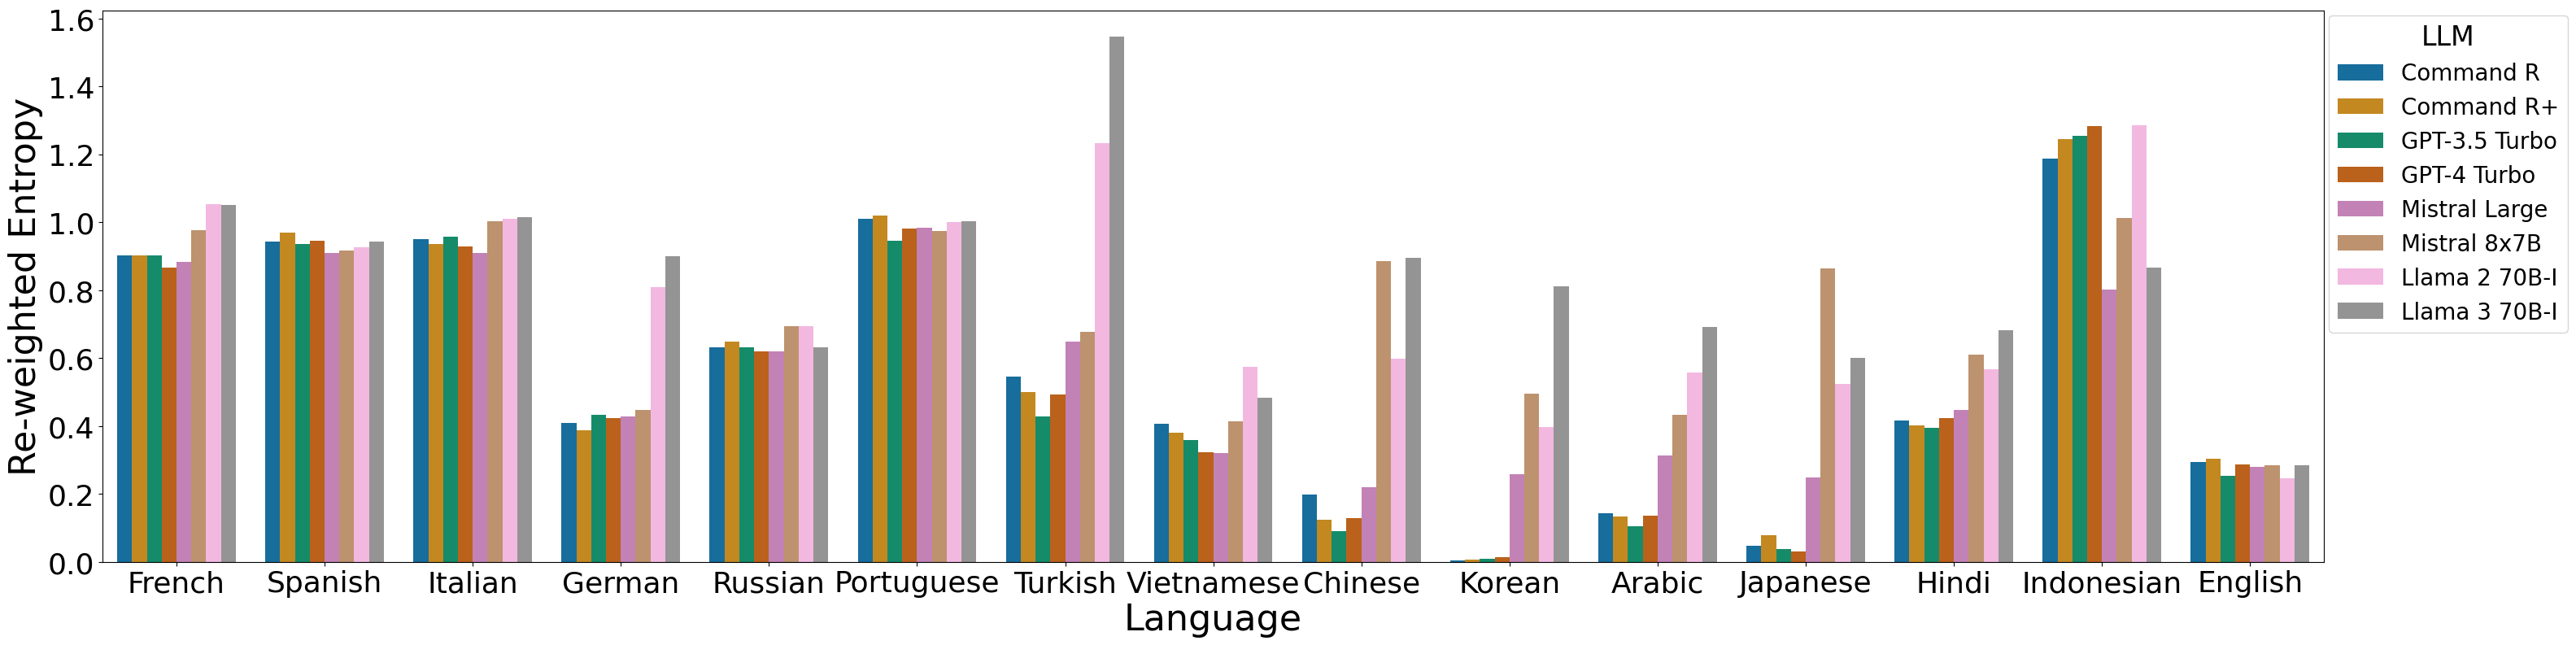

In [167]:
plot_lc_inversion(df_line_mono_sorted,  by_entropy="weighted_entropy", pr="lpr", outputfile="../results/prompting_language_confusion/lcb_word_monolingual_languages.pdf", 
                  generation_setting="monolingual", level="word")

/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_27094/3072051221.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  p = sns.barplot(x='Language', y=f'avg_{level}_weighted_entropy', data=df, hue="LLM_name", palette="colorblind", ax=ax1, ci=None)


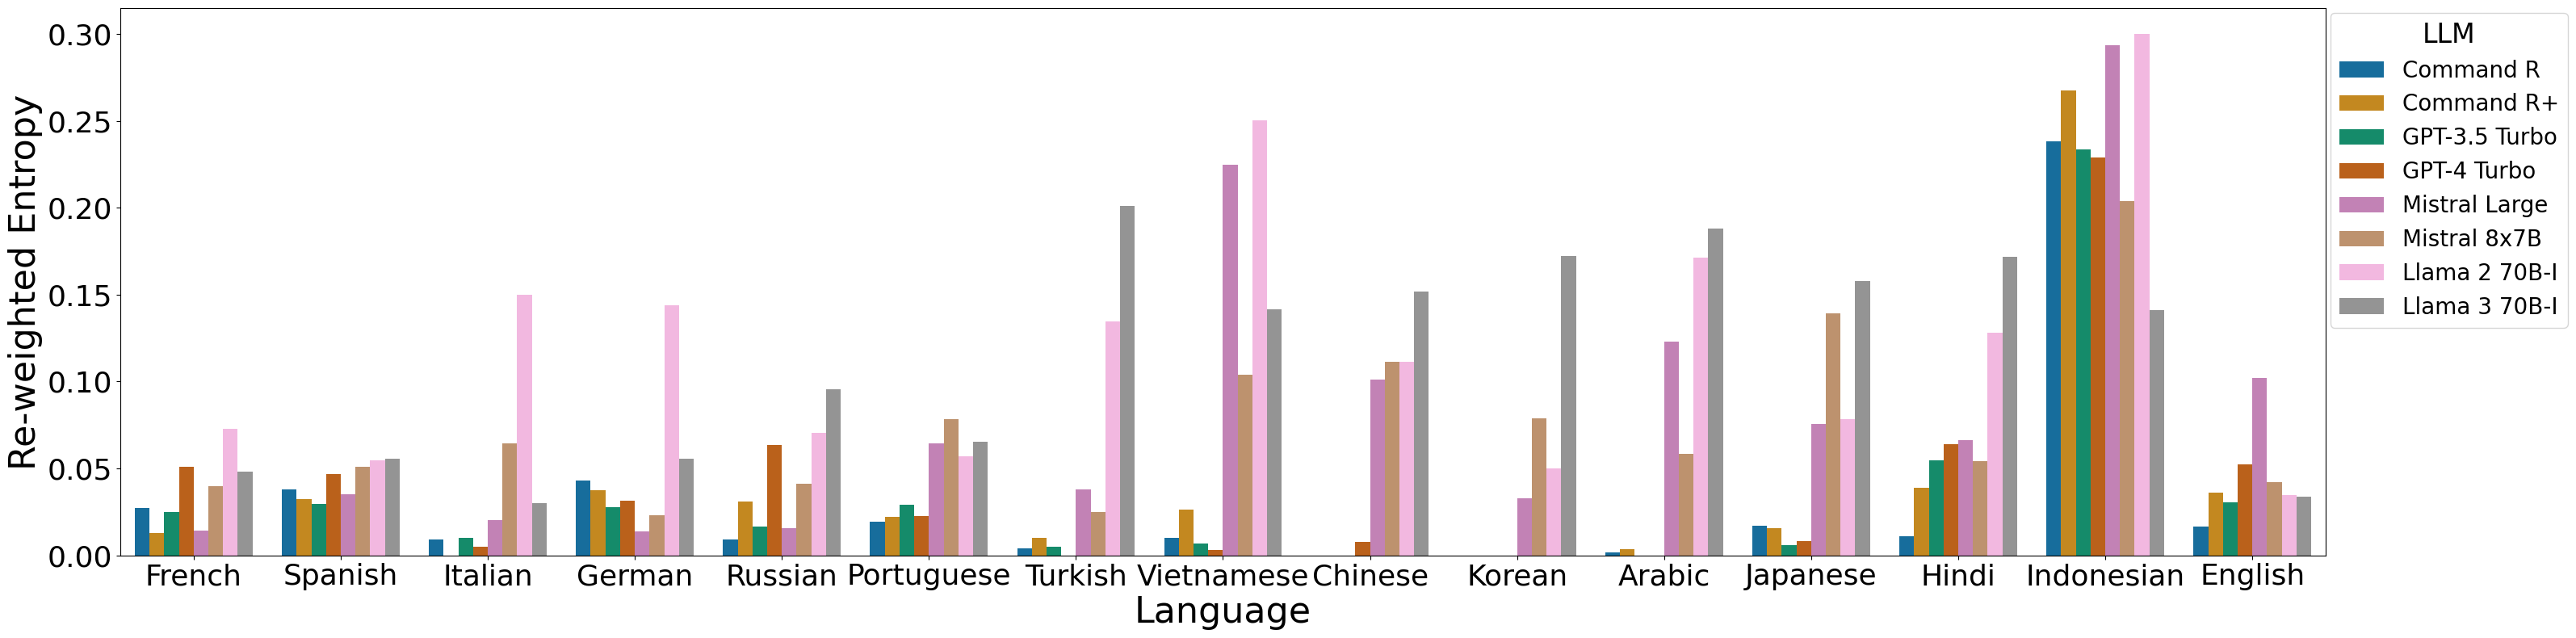

In [166]:
plot_lc_inversion(df_line_mono_sorted,  by_entropy="weighted_entropy", pr="lpr", outputfile="../results/prompting_language_confusion/lcb_line_monolingual_languages.pdf", 
                  generation_setting="monolingual", level="line")

## word level monolingual

In [35]:
df_word_mono_agg= df_line_mono_sorted.groupby(["LLM_name", "task", "Language"], as_index=False).agg( 
    avg_word_weighted_entropy_across_llm_source=("avg_word_weighted_entropy", 'mean'))

df_mono_word= df_word_mono_agg.pivot(index='LLM_name', columns='Language', values='avg_word_weighted_entropy_across_llm_source')
df_mono_word[langs]
df_mono_word[langs].to_csv("../results/prompting_language_confusion/lcb_word_monolingual_languages_lc.csv")

In [36]:
df_mono_word= df_word_mono_agg.pivot(index='LLM_name', columns='Language', values='avg_word_weighted_entropy_across_llm_source')
df_mono_word[langs]

Language,French,Spanish,Italian,German,Russian,Portuguese,Turkish,Vietnamese,Chinese,Korean,Arabic,Japanese,Hindi,Indonesian
LLM_name,,,,,,,,,,,,,,
Command R,0.901576,0.942397,0.951259,0.409792,0.631165,1.009454,0.544514,0.405864,0.197350,0.003146,0.142449,0.046213,0.416110,1.186510
Command R+,0.903386,0.968744,0.936349,0.387340,0.647848,1.018520,0.500269,0.381175,0.123240,0.005681,0.132666,0.078498,0.400725,1.245811
GPT-3.5 Turbo,0.903106,0.934754,0.956656,0.432536,0.632154,0.945707,0.428141,0.358665,0.091332,0.008837,0.105287,0.036995,0.393715,1.253208
GPT-4 Turbo,0.865580,0.945579,0.928393,0.424149,0.620620,0.981772,0.493220,0.321746,0.128736,0.014565,0.135542,0.030706,0.423234,1.282310
Llama 2 70B-I,1.054117,0.925692,1.010874,0.809200,0.693870,1.000030,1.233260,0.574772,0.598852,0.395962,0.557768,0.522890,0.567629,1.286182
Llama 3 70B-I,1.051903,0.942673,1.013927,0.899153,0.632460,1.002767,1.545907,0.482693,0.894910,0.812022,0.690439,0.601676,0.683064,0.865882
Mistral 8x7B,0.976334,0.915708,1.002735,0.447735,0.694719,0.974625,0.676339,0.413351,0.885416,0.495977,0.432998,0.862843,0.610579,1.013405
Mistral Large,0.882933,0.909880,0.908348,0.427038,0.619081,0.982671,0.647302,0.319869,0.219104,0.256847,0.313666,0.248392,0.447202,0.801577


In [37]:
df_mono_word[langs].to_csv("../results/prompting_language_confusion/lcb_word_monolingual_languages_lc.csv")

In [43]:
df_line = df.dropna(subset=["avg_line_weighted_entropy"])

In [44]:
df_line_cross = df[df["task"]=="crosslingual"]

In [45]:
df_line_cross.source.value_counts()

source
complex-prompts    112
okapi              112
sharegpt           112
Name: count, dtype: int64

In [46]:
df_line_cross["LLM"].value_counts()

LLM
command-r           42
command-r-plus      42
gpt-3.5-turbo       42
gpt-4-turbo         42
mistral-large       42
mistral-8x7b        42
llama-2-instruct    42
llama-3-instruct    42
Name: count, dtype: int64

In [47]:
df_lang= df_line_cross.groupby(["LLM", "task", "lang"], as_index=False).agg( 
    avg_line_weighted_entropy_across_llm_source=("avg_line_weighted_entropy", 'mean'))

/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_77234/2746790560.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lang= df_line_cross.groupby(["LLM", "task", "lang"], as_index=False).agg(


In [48]:
report_models = ["command-r",  "command-r-plus", "gpt-3.5-turbo", "gpt-4-turbo", "mistral-large", "mistral-8x7b", 
                 "llama-2-instruct", "llama-3-instruct"]

In [49]:
lang_order= ['fra',
 'spa',
 'ita',
 'deu',
 'rus',
 'por',
 'tur',
 'vie',
 'zho',
 'kor',
 'ara',
 'jpn',
 'hin',
 'ind']

In [50]:
df_line_cross['lang_avg_entropy'] = pd.Categorical(df_line_cross['lang'], categories=lang_order, ordered=True)
df_line_cross["LLM"] = pd.Categorical(df_line_cross["LLM"], categories=report_models,ordered=True)

/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_77234/3926492530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_line_cross['lang_avg_entropy'] = pd.Categorical(df_line_cross['lang'], categories=lang_order, ordered=True)
/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_77234/3926492530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_line_cross["LLM"] = pd.Categorical(df_line_cross["LLM"], categories=report_models,ordered=True)


In [51]:
df_line_cross_sorted= df_line_cross.sort_values(by=["lang_avg_entropy", "LLM"])

In [52]:
df_line_cross_sorted["source"].value_counts()

source
complex-prompts    112
okapi              112
sharegpt           112
Name: count, dtype: int64

In [53]:
# Deng et al., 2023 
# https://arxiv.org/pdf/2310.06474
lang2resource = {
    "French":"HRL", "Spanish":"HRL", "Italian":"HRL",  "German":"HRL", 
    "Russian":"HRL", "Portuguese":"HRL", "Turkish":"HRL", "Vietnamese":"HRL", 
    "Japnaese":"HRL", 
    "Chinese":"HRL",
    "Hindi":"MRL", "Indonesian":"MRL", "Arabic":"MRL", 
    "Korean":"LRL"
}

In [54]:
df_line_cross_avg= df_line_cross_sorted.groupby(["LLM_name", "task", "Language"], as_index=False).agg( 
    avg_line_weighted_entropy_across_llm_source=("avg_line_weighted_entropy", 'mean'))

In [55]:
df_line_cross_pivot = df_line_cross_avg.pivot(index='LLM_name', columns='Language', values='avg_line_weighted_entropy_across_llm_source')


In [288]:
df_line_cross_pivot[langs].to_csv("../results/prompting_language_confusion/lcb_line_crosslingual_languages_lc.csv")


In [56]:
df_line_cross_pivot[langs]

Language,French,Spanish,Italian,German,Russian,Portuguese,Turkish,Vietnamese,Chinese,Korean,Arabic,Japanese,Hindi,Indonesian
LLM_name,,,,,,,,,,,,,,
Command R,0.194217,0.165090,0.172300,0.192800,0.135671,0.145788,0.144067,0.157934,0.100685,0.116912,0.115854,0.152220,0.139489,0.243690
Command R+,0.123419,0.163512,0.080955,0.104028,0.103392,0.155507,0.081738,0.120362,0.060956,0.061679,0.053361,0.069058,0.142375,0.382535
GPT-3.5 Turbo,0.121884,0.108489,0.104202,0.111894,0.074941,0.116880,0.094455,0.077173,0.052668,0.059555,0.076399,0.062410,0.116321,0.258398
GPT-4 Turbo,0.072149,0.095608,0.100177,0.077820,0.087648,0.090945,0.073272,0.074209,0.066543,0.059960,0.066575,0.098062,0.161242,0.257651
Llama 2 70B-I,0.151740,0.133867,0.233035,0.265690,0.218602,0.202225,0.227974,0.253188,0.281668,0.357395,0.371896,0.323285,0.344324,0.343271
Llama 3 70B-I,0.390617,0.319242,0.432364,0.422604,0.449492,0.350297,0.569556,0.536031,0.387200,0.377676,0.519998,0.482244,0.553118,0.693475
Mistral 8x7B,0.134060,0.133185,0.124232,0.158230,0.130357,0.128832,0.115622,0.145807,0.160429,0.174319,0.150568,0.197695,0.305329,0.286112
Mistral Large,0.134141,0.212246,0.180839,0.144119,0.149598,0.250897,0.140969,0.181681,0.294442,0.305165,0.281589,0.341631,0.240694,0.326222


In [57]:
df_line_cross_pivot[langs]

Language,French,Spanish,Italian,German,Russian,Portuguese,Turkish,Vietnamese,Chinese,Korean,Arabic,Japanese,Hindi,Indonesian
LLM_name,,,,,,,,,,,,,,
Command R,0.194217,0.165090,0.172300,0.192800,0.135671,0.145788,0.144067,0.157934,0.100685,0.116912,0.115854,0.152220,0.139489,0.243690
Command R+,0.123419,0.163512,0.080955,0.104028,0.103392,0.155507,0.081738,0.120362,0.060956,0.061679,0.053361,0.069058,0.142375,0.382535
GPT-3.5 Turbo,0.121884,0.108489,0.104202,0.111894,0.074941,0.116880,0.094455,0.077173,0.052668,0.059555,0.076399,0.062410,0.116321,0.258398
GPT-4 Turbo,0.072149,0.095608,0.100177,0.077820,0.087648,0.090945,0.073272,0.074209,0.066543,0.059960,0.066575,0.098062,0.161242,0.257651
Llama 2 70B-I,0.151740,0.133867,0.233035,0.265690,0.218602,0.202225,0.227974,0.253188,0.281668,0.357395,0.371896,0.323285,0.344324,0.343271
Llama 3 70B-I,0.390617,0.319242,0.432364,0.422604,0.449492,0.350297,0.569556,0.536031,0.387200,0.377676,0.519998,0.482244,0.553118,0.693475
Mistral 8x7B,0.134060,0.133185,0.124232,0.158230,0.130357,0.128832,0.115622,0.145807,0.160429,0.174319,0.150568,0.197695,0.305329,0.286112
Mistral Large,0.134141,0.212246,0.180839,0.144119,0.149598,0.250897,0.140969,0.181681,0.294442,0.305165,0.281589,0.341631,0.240694,0.326222


/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_77234/3775847747.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  p = sns.barplot(x='Language', y=f'avg_{level}_weighted_entropy', data=df, hue="LLM_name", palette="colorblind", ax=ax1, ci=None)


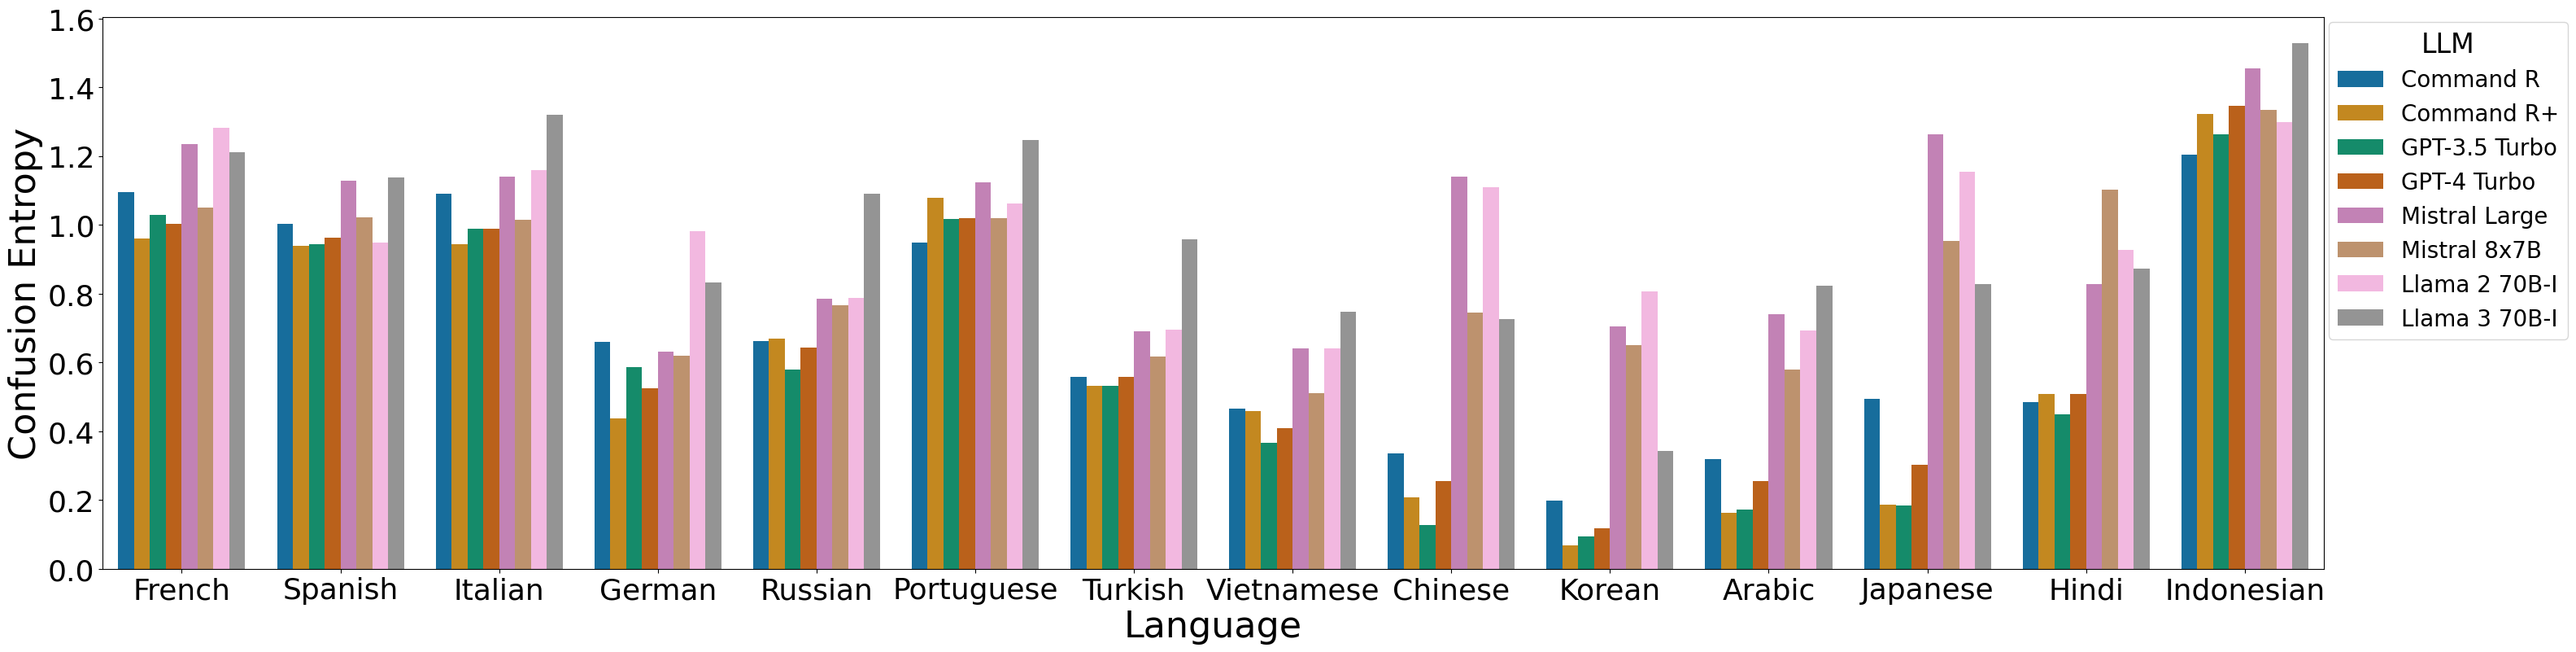

In [58]:
plot_lc_inversion(df_line_cross_sorted,  by_entropy="weighted_entropy", pr="lpr", outputfile="../results/prompting_language_confusion/lcb_word_crosslingual_languages.pdf", 
                  generation_setting="crosslingual", level="word")

/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_77234/3775847747.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  p = sns.barplot(x='Language', y=f'avg_{level}_weighted_entropy', data=df, hue="LLM_name", palette="colorblind", ax=ax1, ci=None)


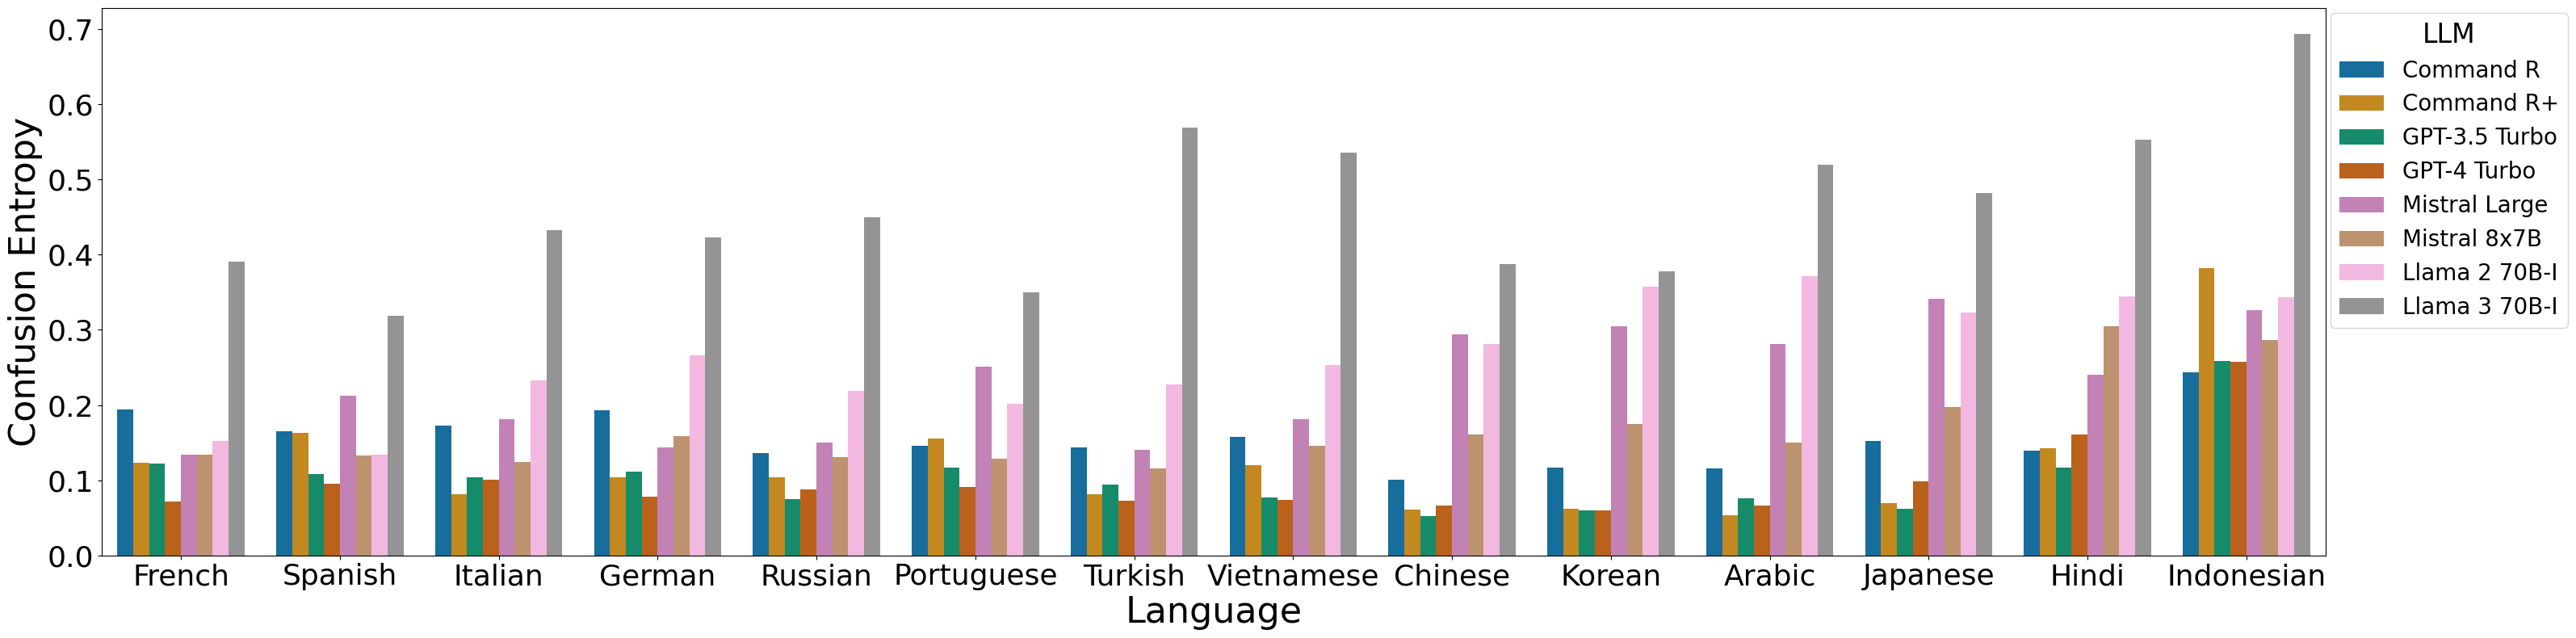

In [59]:
plot_lc_inversion(df_line_cross_sorted,  by_entropy="weighted_entropy", pr="lpr", outputfile="../results/prompting_language_confusion/lcb_line_crosslingual_languages.pdf", 
                  generation_setting="crosslingual", level="line")

In [53]:
df_word_cross_agg= df_line_cross_sorted.groupby(["LLM_name", "task", "Language"], as_index=False).agg( 
    avg_word_weighted_entropy_across_llm_source=("avg_word_weighted_entropy", 'mean'))

df_cross_word = df_word_cross_agg.pivot(index='LLM_name', columns='Language', values='avg_word_weighted_entropy_across_llm_source')
df_cross_word[langs]

Language,French,Spanish,Italian,German,Russian,Portuguese,Turkish,Vietnamese,Chinese,Korean,Arabic,Japanese,Hindi,Indonesian
LLM_name,,,,,,,,,,,,,,
Command R,1.094094,1.003820,1.089630,0.658845,0.661751,0.948738,0.557878,0.466428,0.334699,0.198781,0.319019,0.494281,0.483588,1.202974
Command R+,0.960559,0.937988,0.944421,0.438166,0.668386,1.078457,0.531584,0.457247,0.208113,0.066985,0.161563,0.187021,0.507450,1.321153
GPT-3.5 Turbo,1.029537,0.943942,0.989404,0.585756,0.579631,1.015862,0.532679,0.365938,0.127346,0.093284,0.172744,0.185026,0.447785,1.262638
GPT-4 Turbo,1.002546,0.961853,0.989016,0.525691,0.642463,1.018198,0.556780,0.408854,0.254237,0.118222,0.255157,0.301178,0.507347,1.345081
Llama 2 70B-I,1.282953,0.948819,1.158280,0.982232,0.788459,1.062614,0.696185,0.639849,1.108876,0.806854,0.692942,1.153040,0.926829,1.298301
Llama 3 70B-I,1.211118,1.136584,1.319317,0.832934,1.091077,1.246506,0.956839,0.746151,0.724853,0.343540,0.822755,0.827504,0.873285,1.527373
Mistral 8x7B,1.050928,1.020533,1.014300,0.620278,0.765613,1.018605,0.617370,0.509858,0.744630,0.649636,0.580046,0.952038,1.101658,1.333036
Mistral Large,1.235124,1.128377,1.140893,0.631851,0.785017,1.124396,0.690896,0.640414,1.138793,0.705351,0.741129,1.262552,0.826554,1.455123


In [ ]:
# word level

In [296]:
df_cross_word[langs].to_csv("../results/prompting_language_confusion/lcb_word_crosslingual_languages_lc.csv")

In [42]:
def plot_lc_inversion(df,  by_entropy="weighted_entropy", pr="lpr", outputfile="test.pdf", generation_setting="crosslingual", level="line"):
    # Assuming df_eval_lang_entropy_melted contains columns: 'language', 'entropy', 'step', and 'f1_score'

    # Create the figure and the first axis (for entropy)
    fig, ax1 = plt.subplots(figsize=(32, 8))

    df = df[df["task"]==generation_setting]
    p = sns.barplot(x='Language', y=f'avg_{level}_weighted_entropy', data=df, hue="LLM_name", palette="colorblind", ax=ax1, ci=None)

  

    ax1.set_ylabel("Confusion Entropy", fontsize=32)
    ax1.set_xlabel('Language', fontsize=32)
    ax1.tick_params(axis='y', labelsize=26)
    ax1.tick_params(axis='x', labelsize=26)
    
    # Add the legend for the steps (can be adjusted for both y-axes)
    ax1.legend(title="LLM", fontsize=20, title_fontsize=24, loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.2)
    
    # ax2.legend(title=pr.capitalize(), fontsize=14, title_fontsize=16, loc='upper right', bbox_to_anchor=(1.13, 0.6), borderaxespad=0.2)

    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(outputfile, format='pdf', bbox_inches='tight')

    
    plt.show()


# correlation

In [54]:
from scipy.stats import spearmanr
import numpy as np

In [55]:
def get_annotated_corr(df, corr_method="spearman"):
    rho = df.corr(method=corr_method)
    pval =df.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*rho.shape)
    p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x <= t]))
    # Combine rho (correlation coefficients) and p-values (significance stars)
    annotated = rho.round(2).astype(str) + p
    # Create a mask for the upper triangle and diagonal
    mask = np.triu(np.ones_like(rho, dtype=bool))

    # Mask the upper triangle of the annotated DataFrame
    annotated = annotated.mask(mask)
    return annotated

In [56]:
anno = get_annotated_corr(df[["avg_line_weighted_entropy", "avg_word_weighted_entropy", "lpr", "wpr"]])

/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_27094/1944174085.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x <= t]))


In [57]:
anno

,avg_line_weighted_entropy,avg_word_weighted_entropy,lpr,wpr
avg_line_weighted_entropy,NaN,NaN,NaN,NaN
avg_word_weighted_entropy,0.51***,NaN,NaN,NaN
lpr,-0.83***,-0.3***,NaN,NaN
wpr,-0.29**,-0.5***,0.31**,NaN


In [46]:
anno

,avg_line_weighted_entropy,avg_word_weighted_entropy,lpr,wpr
avg_line_weighted_entropy,NaN,NaN,NaN,NaN
avg_word_weighted_entropy,0.51***,NaN,NaN,NaN
lpr,-0.83***,-0.3***,NaN,NaN
wpr,-0.29**,-0.5***,0.31**,NaN


In [58]:
df_mono = df[df["task"]=="monolingual"]
anno_mono = get_annotated_corr(df_mono[["avg_line_weighted_entropy", "avg_word_weighted_entropy", "lpr", "wpr"]])
anno_mono

/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_27094/1944174085.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x <= t]))


,avg_line_weighted_entropy,avg_word_weighted_entropy,lpr,wpr
avg_line_weighted_entropy,NaN,NaN,NaN,NaN
avg_word_weighted_entropy,0.42***,NaN,NaN,NaN
lpr,-0.72***,-0.23*,NaN,NaN
wpr,0.01,-0.31,0.08,NaN


In [59]:
df_cross = df[df["task"]=="crosslingual"]
anno_cross = get_annotated_corr(df_cross[["avg_line_weighted_entropy", "avg_word_weighted_entropy", "lpr", "wpr"]])
anno_cross

/var/folders/bj/qp6k2wl11h5gpn8j4hg0tgf40000gn/T/ipykernel_27094/1944174085.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x <= t]))


,avg_line_weighted_entropy,avg_word_weighted_entropy,lpr,wpr
avg_line_weighted_entropy,NaN,NaN,NaN,NaN
avg_word_weighted_entropy,0.54***,NaN,NaN,NaN
lpr,-0.87***,-0.38***,NaN,NaN
wpr,-0.27**,-0.47***,0.37***,NaN


In [60]:
len(df.dropna(subset=["wpr"])), len(df.dropna(subset=["lpr"]))

(112, 304)

In [61]:
df.LLM.value_counts()

LLM
command-r           66
command-r-plus      66
gpt-3.5-turbo       66
gpt-4-turbo         66
mistral-large       66
mistral-8x7b        66
llama-2-instruct    66
llama-3-instruct    66
Name: count, dtype: int64

In [62]:
df.task.value_counts()

task
crosslingual    336
monolingual     192
Name: count, dtype: int64

In [63]:
df.source.value_counts()

source
okapi                  192
complex-prompts        112
sharegpt               112
aya-human-annotated     40
dolly-human-edited      40
native-prompts          32
Name: count, dtype: int64